Reading classics [Python Machine Learning 3rd Edition](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part1.ipynb)

In [1]:
from IPython.display import display,HTML
c1,c2,f1,f2,fs1,fs2=\
'#11ff66','#6611ff','Wallpoet','Orbitron',20,10
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' 
    style='font-family:"""+font+\
    """; color:"""+fontcolor+\
    """; font-size:"""+str(fontsize)+"""px;'>
    %s</h1>"""%string))

In [2]:
dhtml('Code Modules, Setting, & Functions')

In [3]:
import warnings,imageio,urllib
import tensorflow as tf,pylab as pl
import pandas as pd,numpy as np
import tensorflow.keras.layers as tkl
import tensorflow.keras.utils as tku
import tensorflow.keras.callbacks as tkc
import tensorflow_datasets as tfds
from sklearn.metrics import \
classification_report,confusion_matrix
from IPython.core.magic import register_line_magic

In [4]:
warnings.filterwarnings('ignore')
pd.set_option('precision',3)
tf.keras.backend.set_floatx('float64')
fw='weights.best.hdf5'
buffer_size,batch_size=10000,64
pixels,pixels2=28,32
num_classes=10

In [5]:
@register_line_magic
def display_examples(pars):
    pars=pars.split()
    data,n=pars[0],int(pars[1])
    if data=='mnist': data=mnist_test
    if data=='cifar': data=cifar_test
    batch=next(iter(data.batch(n)))
    images=batch['image'].numpy()
    labels=batch['label'].numpy() 
    fig=pl.figure(figsize=(2*n//3,4.5))
    for i in range(n):
        ax=fig.add_subplot(3,n//3,i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(np.squeeze(images[i]),
                  cmap='bone')
        ax.text(.85,.15,'{}'.format(labels[i]), 
                fontdict={'color':c1,'fontsize':30},
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
    pl.show()
@register_line_magic
def display_reports(data):
    global model,fw,buffer_size,c2,f2,fs2
    model.load_weights(fw)
    if data=='mnist': data=mnist_test
    if data=='cifar': data=cifar_test
    test_results=model.evaluate(data.batch(buffer_size))
    dhtml('\ntest accuracy: {:.2f}%'\
          .format(test_results[1]*100),
          c2,f2,fs2)
    batch=next(iter(data.batch(buffer_size)))
    y_test=batch[1].numpy()
    py_test=np.argmax(
        model.predict(data.batch(buffer_size)),
                      axis=-1)
    dhtml('Classification Report',c2,f2,fs2)
    print(classification_report(y_test,py_test))
    dhtml('Confusion Matrix',c2,f2,fs2)
    print(confusion_matrix(y_test,py_test))

In [6]:
def history_plot(fit_history):
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color=c1,label='train')
    pl.plot(fit_history.history[keys[2]],
            color=c2,label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color=c1,label='train')
    pl.plot(fit_history.history[keys[3]],
            color=c2,label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()
def cb(fw):
    early_stopping=\
    tkc.EarlyStopping(monitor='val_loss',
                      patience=20,verbose=2)
    checkpointer=\
    tkc.ModelCheckpoint(filepath=fw,
                        save_best_only=True,verbose=2)
    lr_reduction=\
    tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                          patience=5,factor=.75)
    return [checkpointer,early_stopping,
            lr_reduction]

In [7]:
dhtml('Data Processing')

In [8]:
mnist=tfds.builder('mnist')
mnist.download_and_prepare()
ds=mnist.as_dataset(shuffle_files=False,
            split=['train','test'])
mnist_train,mnist_test=ds[0],ds[1]



Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


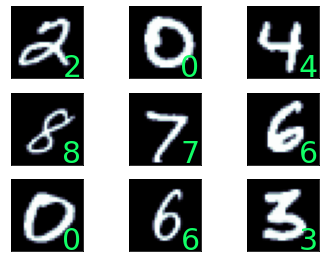

In [9]:
dhtml(mnist.info.features['image'],c2,f2,fs2)
dhtml(mnist.info.features['label'],c2,f2,fs2)
%display_examples mnist 9

In [10]:
mnist_train=mnist_train.map(
    lambda item:(tf.cast(item['image'],tf.float32)/255., 
                 tf.cast(item['label'],tf.int32)))
mnist_test=mnist_test.map(
    lambda item:(tf.cast(item['image'],tf.float32)/255., 
                  tf.cast(item['label'],tf.int32)))
tf.random.set_seed(123)
mnist_train=mnist_train\
.shuffle(buffer_size=buffer_size,
         reshuffle_each_iteration=False)
mnist_valid=mnist_train.take(buffer_size).batch(batch_size)
mnist_train=mnist_train.skip(buffer_size).batch(batch_size)

In [11]:
cifar=tfds.builder('cifar10')
cifar.download_and_prepare()
ds=cifar.as_dataset(shuffle_files=False,
                    split=['train','test'])
cifar_train,cifar_test=ds[0],ds[1]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteQXKURE/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteQXKURE/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


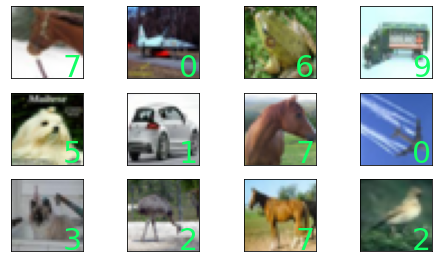

In [12]:
dhtml(cifar.info.features['image'],c2,f2,fs2)
dhtml(cifar.info.features['label'],c2,f2,fs2)
%display_examples cifar 12

In [13]:
cifar_train=cifar_train.map(
    lambda item:(tf.cast(item['image'],tf.float32)/255., 
                 tf.cast(item['label'],tf.int32)))
cifar_test=cifar_test.map(
    lambda item:(tf.cast(item['image'],tf.float32)/255., 
                  tf.cast(item['label'],tf.int32)))
tf.random.set_seed(123)
cifar_train=cifar_train\
.shuffle(buffer_size=buffer_size,
         reshuffle_each_iteration=False)
cifar_valid=cifar_train.take(buffer_size).batch(batch_size)
cifar_train=cifar_train.skip(buffer_size).batch(batch_size)

In [14]:
dhtml('CNN Construction. One Channel')

In [15]:
model=tf.keras.Sequential()
model.add(tkl.Input((pixels,pixels,1),
                    name='input'))
model.add(tkl.Conv2D(
    filters=32,kernel_size=(7,7),
    strides=(1,1),padding='same',
    name='conv_1'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_1'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),name='pool_1'))
model.add(tkl.Dropout(.25,name='drop_1'))
model.add(tkl.Conv2D(
    filters=96,kernel_size=(7,7),
    strides=(1,1),padding='same',
    name='conv_2'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_2'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),name='pool_2'))
model.add(tkl.Dropout(.25,name='drop_2'))
model.compute_output_shape(
    input_shape=(batch_size,pixels,pixels,1))

TensorShape([64, 7, 7, 96])

In [16]:
model.add(tkl.GlobalMaxPooling2D(name='gmpool'))   
model.add(tkl.Dense(512,name='dense_1'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_3'))
model.add(tkl.Dropout(.5,name='drop_3'))
model.compute_output_shape(
    input_shape=(batch_size,pixels,pixels,1))

TensorShape([64, 512])

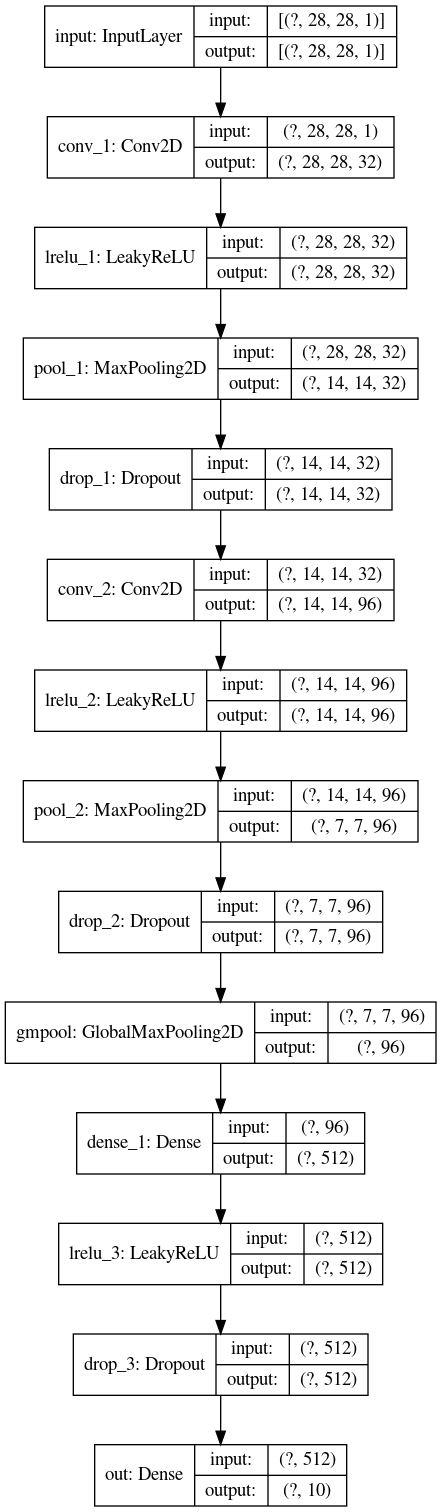

In [17]:
model.add(tkl.Dense(num_classes,name='out',
                    activation='softmax'))
tku.plot_model(model,show_shapes=True)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses\
              .SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history=model.fit(mnist_train,epochs=50,shuffle=True, 
                  validation_data=mnist_valid,
                  callbacks=cb(fw))

Epoch 1/50
782/782 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.9049
Epoch 00001: val_loss improved from inf to 0.07293, saving model to weights.best.hdf5
782/782 [==============================] - 13s 17ms/step - loss: 0.2887 - accuracy: 0.9049 - val_loss: 0.0729 - val_accuracy: 0.9792
Epoch 2/50
778/782 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9776
Epoch 00002: val_loss improved from 0.07293 to 0.05644, saving model to weights.best.hdf5
782/782 [==============================] - 10s 13ms/step - loss: 0.0732 - accuracy: 0.9776 - val_loss: 0.0564 - val_accuracy: 0.9845
Epoch 3/50
781/782 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9836
Epoch 00003: val_loss improved from 0.05644 to 0.03497, saving model to weights.best.hdf5
782/782 [==============================] - 10s 13ms/step - loss: 0.0551 - accuracy: 0.9836 - val_loss: 0.0350 - val_accuracy: 0.9888
Epoch 4/50
781/782 [===========================

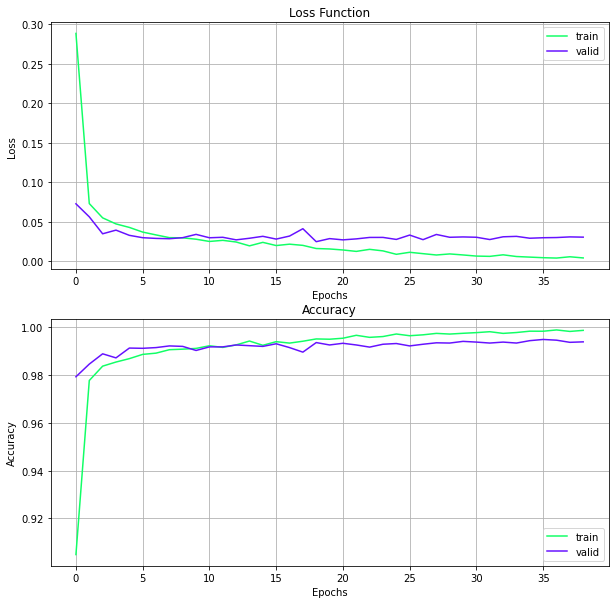

In [19]:
history_plot(history)

In [20]:
%display_reports mnist

1/1 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9938


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       1.00      1.00      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



[[ 976    0    0    0    0    0    2    1    1    0]
 [   0 1129    1    1    1    0    3    0    0    0]
 [   1    0 1031    0    0    0    0    0    0    0]
 [   0    0    0 1005    0    5    0    0    0    0]
 [   0    0    1    0  974    0    1    0    1    5]
 [   1    0    0    4    0  886    1    0    0    0]
 [   4    1    0    0    0    4  948    0    1    0]
 [   0    2    6    0    0    1    0 1018    0    1]
 [   0    1    0    1    0    1    0    0  970    1]
 [   0    0    2    0    5    1    0    0    0 1001]]


In [21]:
dhtml('CNN Construction. Three Channels')

In [22]:
model=tf.keras.Sequential()
model.add(tkl.Input((pixels2,pixels2,3),
                    name='input'))
model.add(tkl.Conv2D(
    filters=32,kernel_size=(7,7),
    strides=(1,1),padding='same',
    name='conv_1'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_1'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),name='pool_1'))
model.add(tkl.Dropout(.25,name='drop_1'))
model.add(tkl.Conv2D(
    filters=196,kernel_size=(7,7),
    strides=(1,1),padding='same',
    name='conv_2'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_2'))
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2,2),name='pool_2'))
model.add(tkl.Dropout(.25,name='drop_2'))
model.compute_output_shape(
    input_shape=(batch_size,pixels2,pixels2,3))

TensorShape([64, 8, 8, 196])

In [23]:
model.add(tkl.GlobalMaxPooling2D(name='gmpool'))   
model.add(tkl.Dense(1024,name='dense_1'))
model.add(tkl.LeakyReLU(alpha=.02,
                        name='lrelu_3'))
model.add(tkl.Dropout(.5,name='drop_3'))
model.compute_output_shape(
    input_shape=(batch_size,pixels2,pixels2,3))

TensorShape([64, 1024])

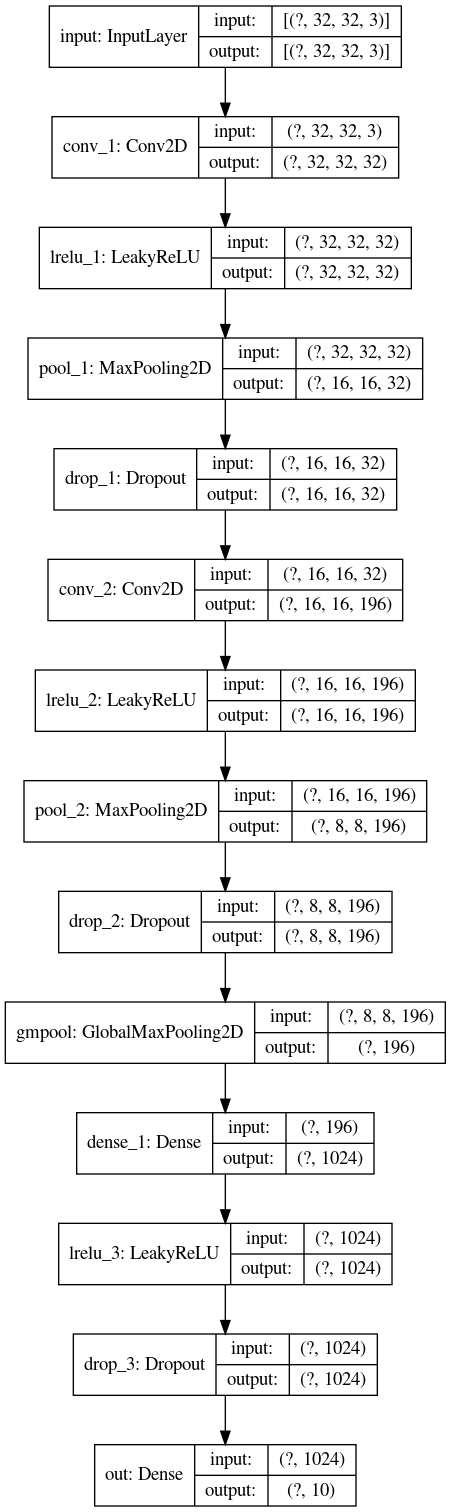

In [24]:
model.add(tkl.Dense(num_classes,name='out',
                    activation='softmax'))
tku.plot_model(model,show_shapes=True)

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses\
              .SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history=model.fit(cifar_train,epochs=70,shuffle=True, 
                  validation_data=cifar_valid,
                  callbacks=cb(fw))

Epoch 1/70
625/625 [==============================] - ETA: 0s - loss: 1.7501 - accuracy: 0.3524
Epoch 00001: val_loss improved from inf to 1.51576, saving model to weights.best.hdf5
625/625 [==============================] - 65s 104ms/step - loss: 1.7501 - accuracy: 0.3524 - val_loss: 1.5158 - val_accuracy: 0.4690
Epoch 2/70
625/625 [==============================] - ETA: 0s - loss: 1.4335 - accuracy: 0.4816
Epoch 00002: val_loss improved from 1.51576 to 1.30931, saving model to weights.best.hdf5
625/625 [==============================] - 62s 100ms/step - loss: 1.4335 - accuracy: 0.4816 - val_loss: 1.3093 - val_accuracy: 0.5420
Epoch 3/70
625/625 [==============================] - ETA: 0s - loss: 1.2900 - accuracy: 0.5369
Epoch 00003: val_loss improved from 1.30931 to 1.19725, saving model to weights.best.hdf5
625/625 [==============================] - 62s 100ms/step - loss: 1.2900 - accuracy: 0.5369 - val_loss: 1.1973 - val_accuracy: 0.5828
Epoch 4/70
625/625 [========================

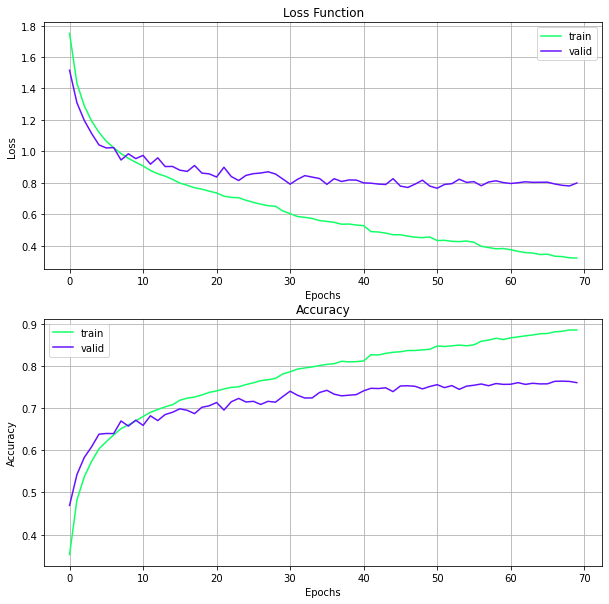

In [26]:
history_plot(history)

In [27]:
%display_reports cifar

1/1 [==============================] - 0s 2ms/step - loss: 0.7773 - accuracy: 0.7534


              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1000
           1       0.89      0.83      0.86      1000
           2       0.69      0.65      0.67      1000
           3       0.58      0.56      0.57      1000
           4       0.66      0.77      0.71      1000
           5       0.69      0.61      0.65      1000
           6       0.78      0.81      0.80      1000
           7       0.83      0.77      0.80      1000
           8       0.87      0.86      0.87      1000
           9       0.79      0.84      0.82      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



[[819  12  42  14  11   7  10   7  54  24]
 [ 18 835   4   4   2   4   8   2  18 105]
 [ 59   4 654  60  90  47  44  29   9   4]
 [ 29   9  63 558  92 119  67  23  10  30]
 [ 23   2  52  49 771  15  40  40   6   2]
 [ 16   3  42 171  56 608  36  47   3  18]
 [  9   4  39  53  54  15 813   2   4   7]
 [ 17   3  33  31  77  50  11 770   0   8]
 [ 58  18  10   9   8   5   5   1 862  24]
 [ 31  52   6  15   7   7   6   8  24 844]]
